<a href="https://colab.research.google.com/github/DavidSenseman/BIO1173/blob/master/Class_04_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---------------------------
**COPYRIGHT NOTICE:** This Jupyterlab Notebook is a Derivative work of [Jeff Heaton](https://github.com/jeffheaton) licensed under the Apache License, Version 2.0 (the "License"); You may not use this file except in compliance with the License. You may obtain a copy of the License at

> [http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

------------------------

# **BIO 1173: Intro Computational Biology**

##### **Module 4: Training for Tabular Data**

* Instructor: [David Senseman](mailto:David.Senseman@utsa.edu), [Department of Integrative Biology](https://sciences.utsa.edu/integrative-biology/), [UTSA](https://www.utsa.edu/)

### Module 4 Material

* Part 4.1: Encoding a Feature Vector for Keras Deep Learning
* **Part 4.2: Keras Multiclass Classification for Deep Neural Networks with ROC and AUC**
* Part 4.3: Keras Regression for Deep Neural Networks with RMSE
* Part 4.4: Backpropagation, Nesterov Momentum, and ADAM Neural Network Training

### Lesson Setup

Run the next code cell to load necessary packages

In [1]:
# You MUST run this code cell first

# Classification neural network
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import svm, datasets

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import scipy.stats as stats
from scipy.stats import zscore
import math

import pandas as pd
import numpy as np

import os
import shutil
path = '/'
memory = shutil.disk_usage(path)
dirpath = os.getcwd()
print("Your current working directory is : " + dirpath)
print("Disk", memory)

Your current working directory is : C:\Users\David\BIO1173_Test\Class_04_2
Disk usage(total=4000108531712, used=1006321041408, free=2993787490304)


### Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow.

In [2]:
# You must run this cell second
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    from google.colab import auth
    auth.authenticate_user()
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
    import requests
    gcloud_token = !gcloud auth print-access-token
    gcloud_tokeninfo = requests.get('https://www.googleapis.com/oauth2/v3/tokeninfo?access_token=' + gcloud_token[0]).json()
    print(gcloud_tokeninfo['email'])
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: not using Google CoLab


## Datasets for Class_04_2

For Class_04_2 we will be using the Pima Indians Diabetes dataset for the Examples, and the Wisconsin Breast Cancer dataset for the **Exercises**.

### **Pima Indians Diabetes Dataset** 

[Pima Indians Diabetes dataset](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)

![___](https://biologicslab.co/BIO1173/images/Pima.jpg)

The **_Pima Indians_** are known for their high prevalence of Type 2 diabetes, making them an important population for studying and understanding the genetic and environmental factors that contribute to the development of diabetes. They have one of the highest rates of diabetes in the world, with some estimates suggesting that up to 50% of Pima adults have the disease.

Studying the Pima Indians has provided valuable insights into the genetic and lifestyle factors that contribute to the development of diabetes, as well as potential strategies for prevention and treatment. Researchers have identified specific genetic variants associated with diabetes in the Pima population, as well as lifestyle factors such as diet and exercise habits that may influence the risk of developing the disease.

![___](https://biologicslab.co/BIO1173/images/PimaParadox.png)

[THE PIMA PARADOX](https://www.newyorker.com/magazine/1998/02/02/the-pima-paradox)

The article by Malcom Gladwell, "THE PIMA PARADOX", that appeared in the January 25, 1998 edition of the New Yorker Magazine, provides a highly readable introduction to this topic.

**Pima Indians Diabetes Dataset**

The datasets consist of several medical predictor (independent) variables and one target (dependent) variable, `Outcome`. Independent variables include the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

Predictor (Independent) Variables:
* **Pregnancies:** Number of times pregnant
* **Glucose:** Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* **BloodPressure:** Diastolic blood pressure (mm Hg)
* **SkinThickness:** Triceps skin fold thickness (mm)
* **Insulin:** 2-Hour serum insulin (mu U/ml)
* **BMI:** Body mass index (weight in kg/(height in m)<sup>2</sup>)
* **DiabetesPedigree:** Diabetes pedigree function
* **Age:** Age (years)

Target (Dependent) Variable
* **Outcome:** Class variable (0 or 1) 268 of 768 are 1, the others are 0
  

### **Breast Cancer Wisconsin (Diagnostic) Data Set** 

[Breast Cancer Wisconsin (Diagnostic) Data Set](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data)

This dataset was described in the previous lesson (Class_04_1). 

The list of features computed from digitized images of breast mass cell nuclei obtained from by FNA in the Breast Cancer Wisconsing datasete are as follows:

**Attribute Information:**

* **ID number**
* **Diagnosis:** (M = malignant, B = benign)

Ten real-valued features are computed for each cell nucleus:

*  **radius:** (mean of distances from center to points on the perimeter)
* **texture:** (standard deviation of gray-scale values)
* **perimeter:**
* **area:**
* **smoothness:** (local variation in radius lengths)
* **compactness:** (perimeter<sup>2</sup> / area - 1.0)
* **concavity:** (severity of concave portions of the contour)
* **concave points:** (number of concave portions of the contour)
* **symmetry:**
* **fractal dimension:** ("coastline approximation" - 1)


# Part 4.2: Multiclass Classification with ROC and AUC

The output of modern neural networks can be of many different forms. However, classically, neural network output has typically been one of the following:

* **Binary Classification** - Classification between two possibilities (positive and negative). Common in medical testing, does the person has the disease (positive) or not (negative).
* **Classification** - Classification between more than 2 possibilites, for example the Iris dataset (3-way classification).
* **Regression** - Numeric prediction.  How many MPG does a car get? (covered in next video)

We will look at some visualizations for all three in this lesson. In particular, we will focus on the importance of evaluating **_false positives_** and **_false negatives_** in the results produced by a neural network. 

## Binary Classification and ROC Charts

Binary classification occurs when a neural network must choose between two options: true/false, yes/no, correct/incorrect, or healthy/diseased. To see how to use binary classification, we will consider a classification system for quantitative cytological measurements of cells extracted from female breast tumors. This system will to classify if a breast tumor is cancerous (malignant) or not (benign). This classification system must decide how to respond to a new patient presenting with a breast tumor.  

When you have only two classes that you can consider, the objective function's score is the number of false-positive predictions versus the number of false negatives. False negatives and false positives are both types of errors, and it is essential to understand the difference. For breast cancer data example, diagnosing a breast tumor as cancerous (malignant) would be positive. A false positive occurs when the model decides the tumor is cancerous when in fact it is benign. A false negative happens when the model decides the tumor is benign when in fact it is cancerous. 

Because only two options exist, we can choose the mistake that is the more serious type of error, a false positive or a false negative. This depends entirely on the situation. 

#### Breast Cancer Diagnosis

In the context of diagnosing breast cancer tumors, a false positive result is generally considered worse than a false negative result in the short-term, but not in the long-term.

* **False positive result:** means that a patient is incorrectly told they have cancer when they do not. This can lead to unnecessary anxiety, invasive follow-up tests, and potentially harmful treatments such as surgery, chemotherapy, and radiation therapy.

* **False negative result:** means that a patient is incorrectly told they do not have cancer when they actually do. This may delay necessary treatment and allow the cancer to progress without intervention, potentially leading to poorer outcomes in the long run.


#### COVID-19 Diagnosis

On the other hand, consider the situation where a model predicts whether a subject has COVID-19. In the context of diagnosing COVID-19, a false negative result is generally considered worse than a false positive result.

* **False negative result:** means that a person is incorrectly told they do not have COVID-19 when they actually do. This can lead to the person unknowingly spreading the virus to others, potentially causing further infections and contributing to community transmission.

* **False positive result:** means that a person is incorrectly told they have COVID-19 when they do not. While this can lead to unnecessary isolation and anxiety for the individual, it typically does not have as severe consequences for public health as a false negative.

While it is not always clear which type of error is more important, it is obvious that having a solid understanding of how neural network models work, and how to assess their predictive accuracy is of paramount importance for their appropriate deployment in a clinical setting and how to explain a model's predictions to patients and their family members.

### Example 1: Read Datafile and Create DataFrame

For the intial examples in this lesson, we will be using the "Pima" dataset that contains clinical information for 768 women of the Pima Indian nation. 

The data file, `pima.csv` is located on the course HTTPS server, located in the following filepath: `/BIO1173/data/`. The code below shows how to read this data file and store the information in a new DataFrame called `pidDF` (Pima Indian Diabetes DataFrame).   

In [3]:
# Example 1: Read datafile and create DataFrame

# Read file and create DataFrame
pidDF = pd.read_csv(
    "https://biologicslab.co/BIO1173/data/pima.csv",
    na_values=['NA','?'])

# Set display options
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 6)

# Display DataFrame
display(pidDF)

,Pregnancies,Glucose,BloodPressure,...,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,...,0.627,50,1
1,1,85,66,...,0.351,31,0
2,8,183,64,...,0.672,32,1
...,...,...,...,...,...,...,...
765,5,121,72,...,0.245,30,0
766,1,126,60,...,0.349,47,1
767,1,93,70,...,0.315,23,0


If your code is correct you should see the following table:

![___](https://biologicslab.co/BIO1173/images/class_04_2_Exm1A.png)


### **Exercise 1: Read Datafile and Create DataFrame**

In the cell below, read the datafile `bcwbreast.csv` containing the _Breast Cancer Wisconsin_ dataset that is located on the course HTTPS server. Create a new DataFrame called `bcwDF` to hold the data.  

The Wisconsin Breast Cancer dataset provides data for 569 patients on 30 features of the cell nuclei obtained from a digitized image of a fine needle aspirate (FNA) of a breast mass. For each patient the cancer was diagnosed as malignant (`M`) or benign (`B`) in the column labeled `diagnosis`.

In [4]:
### Insert your code for Exercise 1 here



If your code is correct you should see the following table:

![__](https://biologicslab.co/BIO1173/images/class_04_1_Exm1B.png)


## ROC Curves


An ROC (Receiver Operating Characteristic) curve is a graphical representation of the performance of a classification model at different threshold settings. It plots the true positive rate (sensitivity) against the false positive rate (1 - specificity) for different threshold values. The curve allows for comparison of different models and helps in determining the optimal threshold for a given model. A higher area under the ROC curve indicates better performance of the model.

Understand how to interpret an ROC curve can be extremely important in medical testing where the result is often **_binary_**, (1) the patient has the disease, (2) the patient does _not_ have the disease. This diagnosis can lead to two types of errors, known as false positives and false negatives:

* **False Positive** - Your test (neural network) indicated that the patient had the disease; however, the patient did not.
* **False Negative** - Your test (neural network) indicated that the patient did not have the disease; however, the patient did have the disease.

And there are two ways that your diagnosis can be correct:

* **True Positive** - Your test (neural network) correctly identified that the patient had the disease.
* **True Negative** - Your test (neural network) correctly identified that the patient did not have the disease.

**Type of Error**
![__](https://biologicslab.co/BIO1173/images/class_4_errors.png)

Neural networks classify in terms of the probability of it being positive. However, at what possibility do you give a positive result? Is the cutoff 50%? 90%? Where you set this cutoff is called the **_threshold_**. Anything above the cutoff is positive; anything below is negative. Setting this cutoff allows the model to be more sensitive or specific.

* **Sensitivity** of a test refers to its ability to correctly identify individuals who have the condition or disease (true positive rate). A highly sensitive test will correctly identify all or most of the individuals with the condition, resulting in few false negative results.

* **Specificity** of a test, on the other hand, refers to its ability to correctly identify individuals who do not have the condition or disease (true negative rate). A highly specific test will correctly identify all or most of the individuals without the condition, resulting in few false positive results.

The key point is this: 

* **_Sensitivity_** focuses on the ability of a test to correctly identify individuals with the condition
* **_Specificity_** focuses on the ability to correctly identify individuals without the condition. 

More info on Sensitivity vs. Specificity: [Khan Academy](https://www.youtube.com/watch?v=Z5TtopYX1Gc)

### XY plot illustrating Sensitivity vs. Specificity

The code in the cell below generates an XY plot illustrating the inherent trade-off between test sensitivity and test specificity.

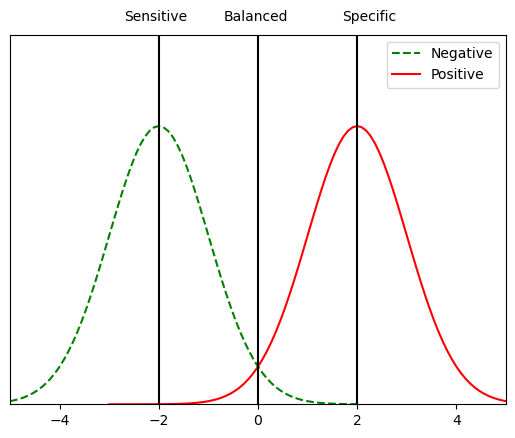

In [5]:
# Generate XY Plot

%matplotlib inline

mu1 = -2
mu2 = 2
variance = 1
sigma = math.sqrt(variance)
x1 = np.linspace(mu1 - 5*sigma, mu1 + 4*sigma, 100)
x2 = np.linspace(mu2 - 5*sigma, mu2 + 4*sigma, 100)
plt.plot(x1, stats.norm.pdf(x1, mu1, sigma)/1,color="green", 
         linestyle='dashed')
plt.plot(x2, stats.norm.pdf(x2, mu2, sigma)/1,color="red")
plt.axvline(x=-2,color="black")
plt.axvline(x=0,color="black")
plt.axvline(x=+2,color="black")
plt.text(-2.7,0.55,"Sensitive")
plt.text(-0.7,0.55,"Balanced")
plt.text(1.7,0.55,"Specific")
plt.ylim([0,0.53])
plt.xlim([-5,5])
plt.legend(['Negative','Positive'])
plt.yticks([])
plt.show()

**Why not simply make a great test that is both highly sensitve and highly specific?**

A test _cannot_ be both highly sensitive and highly specific simultaneously due to inherent trade-offs in test characteristics. In general, increasing sensitivity tends to decrease specificity, and vice versa. This is because the parameters that contribute to sensitivity (true positive rate) and specificity (true negative rate) are often inversely related.

* **Sensitivity** focuses on minimizing false negatives, which means it aims to correctly identify all individuals with the condition. To achieve high sensitivity, the test may be designed to detect even low levels of the condition, making it more likely to generate false positives (lower specificity).

* **Specificity** aims to minimize false positives by correctly identifying individuals without the condition. To achieve high specificity, the test may be designed to only detect the presence of the condition with a high degree of certainty, potentially leading to missed detections of milder cases (lower sensitivity).

Therefore, to maximize sensitivity, a test may detect even slight signals of the condition, increasing the likelihood of false positives and reducing specificity. Conversely, a test designed for high specificity may require stronger, more specific indicators of the condition, potentially missing milder cases and reducing sensitivity. Achieving a balance between sensitivity and specificity is crucial in developing effective diagnostic tests.


### Example 2: Preprocess Data for Neural Network Training

As usual, we will have to pre-process the Pima data in the DataFrame `pidDF` before it can be used to train a neural network. All of the data in `pidDF` is numeric, so it won't be necessary to One-Hot encode any categorical variables (strings). 

However, there are rather large differences in magnitude between different categories. For example, the average (mean) `Glucose` value = 120.894531, while the mean for the category `DiabetesPedigree` is only 0.471876. 

Its not that neural networks can't work with large and small numerical values at the same time, it's just that they **train better** when all of the data is similar in size. This can be achieve using data **_standarization_**. In the cell below we use a very common technique for standarization, converting each number to it's Z-score value.

We beging by making a list of columns that we want to include in our standarization. In this example, we want to use all of the columns, except the column `Outcome`. Here is the code chunk to do this:
~~~text
# Generate column list for preprocessing 
pidX_columns = pidDF.columns.drop('Outcome')
~~~

Next we use the `for` loop to "loop through" each column in the column list, and convert the numerical values in that column to its z-score equivalent:

~~~text
# Replace values with their Z-scores
for col in pidX_columns:
    pidDF[col] = zscore(pidDF[col])
~~~
In this dataset, that's all the preprocessing that needs to be done. We can then generate our X feature vector and our Y feature vector in the usual way (e.g. see Class_04_1). 

Finally, we print out the first 4 values of our X and Y feature vectors to make sure they are in the correct format.


In [6]:
# Example 2: Pre-process data

# Generate column list for preprocessing
pidX_columns = pidDF.columns.drop('Outcome')

# Replace values with their Z-scores
for col in pidX_columns:
    pidDF[col] = zscore(pidDF[col])

# Generate X feature vector
pidX = pidDF[pidX_columns].values
pidX = np.asarray(pidX).astype(np.float32)

# Generate Y as Numpy array
pidY = pidDF['Outcome']   
pidY = np.asarray(pidY).astype(np.float32)    

# Print out X and Y
np.set_printoptions(suppress=True,precision=4)
print("The first 4 X-values are:")
print(pidX[0:4])
print("\nTheir corresponding Y-values are:")
print(pidY[0:4])

The first 4 X-values are:
[[ 0.6399  0.8483  0.1496  0.9073 -0.6929  0.204   0.4685  1.426 ]
 [-0.8449 -1.1234 -0.1605  0.5309 -0.6929 -0.6844 -0.3651 -0.1907]
 [ 1.2339  1.9437 -0.2639 -1.2882 -0.6929 -1.1033  0.6044 -0.1056]
 [-0.8449 -0.9982 -0.1605  0.1545  0.1233 -0.494  -0.9208 -1.0415]]

Their corresponding Y-values are:
[1. 0. 1. 0.]


If your code is correct you should see the following output:

~~~text
The first 4 X-values are:
[[ 0.6399  0.8483  0.1496  0.9073 -0.6929  0.204   0.4685  1.426 ]
 [-0.8449 -1.1234 -0.1605  0.5309 -0.6929 -0.6844 -0.3651 -0.1907]
 [ 1.2339  1.9437 -0.2639 -1.2882 -0.6929 -1.1033  0.6044 -0.1056]
 [-0.8449 -0.9982 -0.1605  0.1545  0.1233 -0.494  -0.9208 -1.0415]]

Their corresponding Y-values are:
[1. 0. 1. 0.]
~~~

By inspection, you can see the X-values have been converted in their Z-score. Notice that z-scores are small values, near `0`, that can be both positive or negative. A z-score that is positive, it means that its original value was greater than column's average (mean). A z-score that is negative means that its original value was less than column's average (mean). If by chance, a you find a z-score = 0.00000, that means the original value just happen to exactly the same value as the mean.

---------------------------------

## **Z-scores**

Z-scores are a method of standardizing values by expressing them in terms of standard deviations from the mean. To calculate a z-score, you subtract the mean of the dataset from a specific value and then divide by the standard deviation. This normalization process allows for comparison of values across different datasets and variables, as it puts everything on a common scale.

Z-scores are important because they allow for the transformation of raw data into a standardized form, making it easier to interpret and analyze. They can help identify outliers in a dataset, determine the relative position of a data point within a distribution, and assess the significance of a particular value compared to the overall dataset. Z-scores are commonly used in various fields such as statistics, finance, and psychology to compare and evaluate data in a meaningful way.

---------------------------------

### **Exercise 2: Preprocess Data for Neural Network Training**

In the cell below you are write the code to preprocess the Breast Cancer Wisconsin data in the DataFrame `bcwDF`. Start by generating a list of columns to be used as X, `bcwX_columns`. To do this, begin by dropping the two columns using this line of code:

~~~text
bcwX_columns = bcwDF.columns.drop('diagnosis').drop('id')`
~~~

The column `id` should be dropped since it doesn't provide any useful information for making predictions about breast cancer while the column `diagnosis` needs to be dropped since it is the target column (Y). 

As shown in Example 2, replace the X values in `bcwX_columns` with their z-scores and then generate a Numpy array called `bcwX`. 

Unlike the Pima data preprocessed in Example 2, the target column `diagnosis` contains the categorical values 'M' for malignant and 'B' for benign. You will need to map the letter 'M' to the integer `1` and the letter `B` to the integer `0`.  

You can use the following line of code to combine both the mapping and the creation of the Y feature vector with a single line of code:
~~~text
# Generate Y feature vector
bcwY = bcwDF['diagnosis'].map({'M':1,"B":0}).values`
~~~

Finally, print out the first 4 values in your X and Y feature vectors.

In [7]:
# Insert your code for Exercise 2 here



If your code is correct you should see the following output:

~~~text
The first 4 X-values are:
[[-1.729   1.0971 -2.0733  1.2699  0.9844  1.5685  3.2835  2.6529  2.5325
   2.2175  2.2557  2.4897 -0.5653  2.833   2.4876 -0.214   1.3169  0.724
   0.6608  1.1488  0.9071  1.8867 -1.3593  2.3036  2.0012  1.3077  2.6167
   2.1095  2.2961  2.7506  1.937 ]
 [-1.7229  1.8298 -0.3536  1.686   1.9087 -0.827  -0.4871 -0.0238  0.5481
   0.0014 -0.8687  0.4993 -0.8762  0.2633  0.7424 -0.6054 -0.6929 -0.4408
   0.2602 -0.8055 -0.0994  1.8059 -0.3692  1.5351  1.8905 -0.3756 -0.4304
  -0.1467  1.0871 -0.2439  0.2812]
 [-1.7168  1.5799  0.4562  1.5665  1.5589  0.9422  1.0529  1.3635  2.0372
   0.9397 -0.398   1.2287 -0.7801  0.8509  1.1813 -0.297   0.815   0.2131
   1.4248  0.237   0.2936  1.5119 -0.024   1.3475  1.4563  0.5274  1.0829
   0.855   1.955   1.1523  0.2014]
 [-1.7107 -0.7689  0.2537 -0.5927 -0.7645  3.2836  3.4029  1.9159  1.4517
   2.8674  4.9109  0.3264 -0.1104  0.2866 -0.2884  0.6897  2.7443  0.8195
   1.115   4.7327  2.0475 -0.2815  0.134  -0.2499 -0.55    3.3943  3.8934
   1.9896  2.1758  6.046   4.935 ]]

Their corresponding Y-values are:
[1. 1. 1. 1.]
~~~

### Define functions for plotting

The code cell below defines two functions that we will used later. The first function, `plot_confusion_matrix()` plots a confusion matrix. The second function, `plot_roc()` plots a ROC chart.

In [8]:
# Define functions

%matplotlib inline

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', 
                            cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

There should be no output when you run the code cell above. 

### Example 3: Construct, Compile and Train Binary Classification Neural Network

The code in the cell below, uses the Keras/Tensorflow libraries to construct, compile and train a binary classificantion neural network called `pidModel` with 3 hidden layers. 

The model `pidModel` is designed to predict whether a women has Type II diabetes based on a several clinical measures. The model is trained (fitted) to the clinical data stored in the feature vectors `pidX` and `pidY`. A monitor function, `pidMonitor`, is also created. This monitor function to allow for Early Stopping when the validation loss fails to improve after waiting for 10 epochs. Training (fitting) is set for 1000 epochs, but the training will stop before reaching 1000 due to Early Stopping. 


In [9]:
# Example 3: Construct, Compile and Train

# Split into train/test---------------------------------------------------------
pidX_train, pidX_test, pidY_train, pidY_test = train_test_split(    
    pidX, pidY, test_size=0.25, random_state=42)

# Construct model---------------------------------------------------------------
pidModel = Sequential()
pidModel.add(Dense(100, input_dim=pidX.shape[1], activation='relu',
                kernel_initializer='random_normal'))
pidModel.add(Dense(50,activation='relu',kernel_initializer='random_normal'))
pidModel.add(Dense(25,activation='relu',kernel_initializer='random_normal'))
pidModel.add(Dense(1,activation='sigmoid',kernel_initializer='random_normal'))

# Compile model------------------------------------------------------------------
pidModel.compile(loss='binary_crossentropy', 
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics =['accuracy'])

# Create monitor------------------------------------------------------------------
pidMonitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
    patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Train model---------------------------------------------------------------------
pidModel.fit(pidX_train,pidY_train,validation_data=(pidX_test,pidY_test),
          callbacks=[pidMonitor],verbose=2,epochs=1000)


Epoch 1/1000
18/18 - 1s - loss: 0.6879 - accuracy: 0.6562 - val_loss: 0.6793 - val_accuracy: 0.6406 - 945ms/epoch - 52ms/step
Epoch 2/1000
18/18 - 0s - loss: 0.6514 - accuracy: 0.6771 - val_loss: 0.6188 - val_accuracy: 0.7083 - 115ms/epoch - 6ms/step
Epoch 3/1000
18/18 - 0s - loss: 0.5526 - accuracy: 0.7292 - val_loss: 0.5440 - val_accuracy: 0.7448 - 104ms/epoch - 6ms/step
Epoch 4/1000
18/18 - 0s - loss: 0.4868 - accuracy: 0.7639 - val_loss: 0.5367 - val_accuracy: 0.6979 - 119ms/epoch - 7ms/step
Epoch 5/1000
18/18 - 0s - loss: 0.4576 - accuracy: 0.7882 - val_loss: 0.5349 - val_accuracy: 0.7188 - 104ms/epoch - 6ms/step
Epoch 6/1000
18/18 - 0s - loss: 0.4446 - accuracy: 0.7934 - val_loss: 0.5378 - val_accuracy: 0.7240 - 102ms/epoch - 6ms/step
Epoch 7/1000
18/18 - 0s - loss: 0.4421 - accuracy: 0.7899 - val_loss: 0.5336 - val_accuracy: 0.7396 - 128ms/epoch - 7ms/step
Epoch 8/1000
18/18 - 0s - loss: 0.4350 - accuracy: 0.7847 - val_loss: 0.5354 - val_accuracy: 0.7396 - 168ms/epoch - 9ms/step

If your code is correct you should see something similiar to the output below:
~~~text
Epoch 1/1000
18/18 - 1s - loss: 0.6891 - accuracy: 0.6476 - val_loss: 0.6825 - val_accuracy: 0.6406 - 624ms/epoch - 35ms/step
Epoch 2/1000
18/18 - 0s - loss: 0.6651 - accuracy: 0.6545 - val_loss: 0.6360 - val_accuracy: 0.6406 - 107ms/epoch - 6ms/step
Epoch 3/1000
18/18 - 0s - loss: 0.5800 - accuracy: 0.6545 - val_loss: 0.5619 - val_accuracy: 0.6406 - 106ms/epoch - 6ms/step
Epoch 4/1000
18/18 - 0s - loss: 0.5093 - accuracy: 0.7205 - val_loss: 0.5506 - val_accuracy: 0.7500 - 103ms/epoch - 6ms/step
Epoch 5/1000
18/18 - 0s - loss: 0.4807 - accuracy: 0.7726 - val_loss: 0.5384 - val_accuracy: 0.7240 - 103ms/Epoch 6/1000
18/18 - 0s - loss: 0.4619 - accuracy: 0.7882 - val_loss: 0.5420 - val_accuracy: 0.7292 - 100ms/epoch - 6ms/step
Epoch 7/1000
18/18 - 0s - loss: 0.4472 - accuracy: 0.7882 - val_loss: 0.5434 - val_accuracy: 0.7240 - 99ms/epoch - 6ms/step
Epoch 8/1000
18/18 - 0s - loss: 0.4402 - accuracy: 0.7830 - val_loss: 0.5394 - val_accuracy: 0.7344 - 99ms/epoch - 6ms/step
Epoch 9/1000
18/18 - 0s - loss: 0.4347 - accuracy: 0.7882 - val_loss: 0.5451 - val_accuracy: 0.7344 - 101ms/epoch - 6ms/step
Epoch 10/1000
Restoring model weights from the end of the best epoch: 5.
18/18 - 0s - loss: 0.4347 - accuracy: 0.7830 - val_loss: 0.5471 - val_accuracy: 0.7448 - 111ms/epoch - 6ms/step
Epoch 10: early stopping

<keras.callbacks.History at 0x1f657191f40>
~~~

In this instance, the model `pidModel` reached a minimum validation loss (`val_loss: 0.5384`) after only 5 epochs!

### **Exercise 3: Construct, Compile and Train Binary Classification Neural Network**

In the cell below, use the Keras/Tensorflow libraries to construct, compile and train a binary classificantion neural network called `bcwModel` with 3 hidden layers using Example 3 as a template.

Your model should be designed to predict whether a breast tumor is cancerous (malignant) or benign after fitting it to the clinical data stored in the feature vectors `bcwX` and `bcwY`.

Create a monitor function called `bcwMonitor` to allow for EarlyStopping when validation loss fails to improve after waiting for 10 epochs. Set the training (fitting) for 1000 epochs.


In [10]:
# Insert your code for Exercise 3 here:




If your code is correct you should see something similiar to the following output:

~~~text
Epoch 1/1000
14/14 - 1s - loss: 0.6847 - accuracy: 0.8357 - val_loss: 0.6628 - val_accuracy: 0.9650 - 637ms/epoch - 45ms/step
Epoch 2/1000
14/14 - 0s - loss: 0.6179 - accuracy: 0.9413 - val_loss: 0.5148 - val_accuracy: 0.9580 - 137ms/epoch - 10ms/step
Epoch 3/1000
14/14 - 0s - loss: 0.3915 - accuracy: 0.9507 - val_loss: 0.2044 - val_accuracy: 0.9580 - 121ms/epoch - 9ms/step
Epoch 4/1000
14/14 - 0s - loss: 0.1579 - accuracy: 0.9577 - val_loss: 0.0740 - val_accuracy: 0.9720 - 102ms/epoch - 7ms/step
Epoch 5/1000
14/14 - 0s - loss: 0.0831 - accuracy: 0.9812 - val_loss: 0.0543 - val_accuracy: 0.9790 - 102ms/epoch - 7ms/step

........................

Epoch 11/1000
14/14 - 0s - loss: 0.0330 - accuracy: 0.9906 - val_loss: 0.0443 - val_accuracy: 0.9790 - 96ms/epoch - 7ms/step
Epoch 12/1000
14/14 - 0s - loss: 0.0298 - accuracy: 0.9930 - val_loss: 0.0463 - val_accuracy: 0.9790 - 96ms/epoch - 7ms/step
Epoch 13/1000
14/14 - 0s - loss: 0.0275 - accuracy: 0.9953 - val_loss: 0.0439 - val_accuracy: 0.9790 - 97ms/epoch - 7ms/step
Epoch 14/1000
14/14 - 0s - loss: 0.0247 - accuracy: 0.9953 - val_loss: 0.0412 - val_accuracy: 0.9790 - 98ms/epoch - 7ms/step
Epoch 15/1000
Restoring model weights from the end of the best epoch: 10.
14/14 - 0s - loss: 0.0227 - accuracy: 0.9930 - val_loss: 0.0440 - val_accuracy: 0.9790 - 97ms/epoch - 7ms/step
Epoch 15: early stopping

<keras.callbacks.History at 0x1f6577596a0>
~~~
In this instance, your model `bcwModel` reached a minimum validation loss (`val_loss: 0.0463`) after only 12 epochs.


-----------------------------------------

## ROC Curves

**_Receiver Operating Characteristic (ROC) Curve_** is a graphical representation that illustrates the diagnostic ability of a binary classification system as its discrimination threshold is varied. The ROC curve plots the true positive rate (Sensitivity) against the false positive rate (1-Specificity) for various threshold values, showing the trade-off between sensitivity and specificity.

The ROC curve is important in evaluating the performance of diagnostic tests or classification models as it provides a comprehensive assessment of their ability to discriminate between positive and negative cases. Some key reasons why ROC curves are important include:

* **Quantitative Measure:** ROC curves provide a quantitative measure of the diagnostic accuracy of a test by summarizing its performance across all possible thresholds.

* **Comparison:** ROC curves allow for a direct comparison of different tests or models based on their area under the curve (AUC), where a higher AUC indicates better overall performance.

* **Threshold Selection:** ROC curves help in selecting the optimal threshold for classification that balances sensitivity and specificity based on the specific requirements of the application.

* **Visual Representation:** The visual nature of ROC curves facilitates a clear understanding of the trade-offs between sensitivity and specificity, aiding in decision-making and interpretation of test results.

--------------------------------------


### Example 4: Plot ROC curve for the Model

The code in the cell below uses the model, `pidModel`, to **_predict_** whether each of the 192 women who were randomly placed in the `pidX_test` dataset, had Type II diabetes based on their clinical values. 

It then sends these predictions all with the women's actual diagnosis, stored in `bcwY_test`, to the plotting function, `plot_roc()` defined earlier in this lesson. 

Using the predicted and the actual values, the plotting function generates an ROC curve for the `pidModel` model.  

6/6 [==============================] - 0s 6ms/step


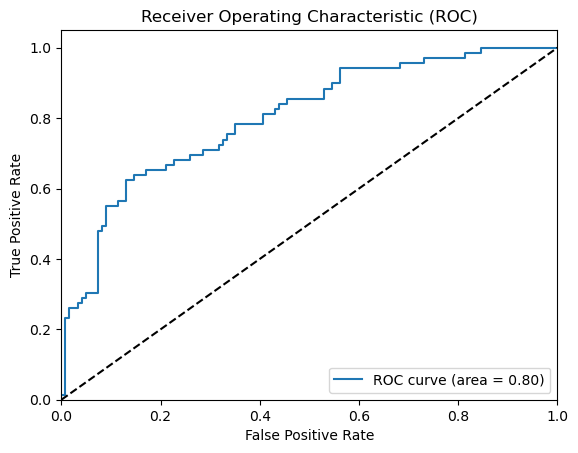

In [11]:
# Example 4: Plot ROC curve

# Use model to generate predictions
pidPred = pidModel.predict(pidX_test)

# Plot model predictions against actual values
plot_roc(pidPred,pidY_test)

Here is an annotated version of a similar ROC plot from the `pidModel` model.

![ROC Curve ](https://biologicslab.co/BIO1173/images/class_04_2_ROC1B.png)

### ROC Curve: Receiver Operating Characteristic Curve

ROC curve stands for "Receiver Operating Characteristic Curve". The ROC Curve above shows the performance of the classification model `piModel` at all classification thresholds for predicting whether a Pima women has Type II diabetes. 

This curve plots two parameters:

* True Positive Rate (Sensitivity)
* False Positive Rate

**True Positive Rate (TPR)** is a synonym for _sensitivity_ and is defined as follows:

$TPR=\frac{TP}{TP+FN}$

In other words, the sensitivity of the model (True Positive Rate) increases to a perfect score (1.0) as the False Negative rate decreases to zero.

**False Positive Rate (FPR)** is defined as follows:

$FPR=\frac{FP}{FP+TN}$

In other words, the False Positive Rate increases to a perfect score (1.0) as the True Negative rate decreases to zero.

An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. 

### AUC: Area Under the ROC Curve

AUC stands for "Area under the ROC Curve." In the plot above, the area colored light blue is the AUC. AUC measures the entire two-dimensional area underneath the entire ROC curve (think integral calculus) from (0,0) to (1,1).

AUC provides an aggregate measure of performance across all possible classification thresholds. One way of interpreting AUC is as the probability that the model ranks a random positive example more highly than a random negative example.

AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0. In this example, the AUC of the model `piModel` was 0.80.

AUC is desirable for the following two reasons:

* AUC is **scale-invariant**. It measures how well predictions are ranked, rather than their absolute values.
 
* AUC is **classification-threshold-invariant**. It measures the quality of the model's predictions irrespective of what classification threshold is chosen.

### **Exercise 4: Plot ROC curve for the Model**

In the cell below write the code to generate a ROC plot of your Breast Cancer classsification model, `bcwModel`.

In [12]:
# Insert your code for Exercise 4 here



If code is correct you should see the following ROC curve:

![ROCCurve](https://biologicslab.co/BIO1173/images/class_04_2_ROC2a.png)

Compared to the Pima classification model, `piModel`, the ROC curve shows that your Breast Cancer model, `bcwModel` is much more accurate since its AUC (area under the curve) = 1.0.

## Multiclass Classification Error Metrics

If you want to predict more than one outcome, you will need more than one output neuron. Because a single neuron can predict two results, (e.g. `0` for "no", `1` for "yes") neural networks with only two output neurons are somewhat rare. 

However, with three or more outcomes, there will be three or more output neurons. The following sections will examine several metrics for evaluating classification error in multiclass situtations. 

--------------------------------------

## ST Segment 

(This vignette is from the [article](https://litfl.com/st-segment-ecg-library/) by Ed Burns and Robert Buttner, Mar 16, 2022)

The **_ST segment_** is the flat, isoelectric section of the ECG between the end of the S wave (the J point) and the beginning of the T wave.

* The ST Segment represents the interval between ventricular depolarization and repolarization.
* The most important cause of ST segment abnormality (elevation or depression) is **myocardial ischaemia** or **infarction**.

![ST Segment](https://biologicslab.co/BIO1173/images/ECG_ST.jpg)

**Causes of ST Segment Elevation**

* [Acute myocardial infarction](https://litfl.com/anterior-myocardial-infarction-ecg-library/)
* [Coronary vasospasm (Printzmetal’s angina)](https://www.ncbi.nlm.nih.gov/pubmed/15293589)
* [Pericarditis](https://litfl.com/pericarditis-ecg-library/)
* [Benign early repolarization](https://litfl.com/benign-early-repolarisation-ecg-library/)
* [Left bundle branch block](https://litfl.com/left-bundle-branch-block-lbbb-ecg-library/)
* [Left ventricular hypertrophy](https://litfl.com/left-bundle-branch-block-lbbb-ecg-library/)
* [Ventricular aneurysm](https://litfl.com/left-ventricular-aneursym-ecg-library/)
* [Brugada syndrome](https://litfl.com/brugada-syndrome-ecg-library/)
* [Ventricular paced rhythm](https://litfl.com/pacemaker-rhythms-normal-patterns/)
* [Raised intracranial pressure](https://litfl.com/raised-intracranial-pressure-ecg-library/)
* [Takotsubo Cardiomyopathy](https://litfl.com/tako-tsubo-cardiomyopathy-ecg-library/)

---------------------------------------

### Example 5: Read Datafile and Create DataFrame

For the next section in this lesson, we will be using the Heart Disease dataset for the Examples. The data file, `heart_disease.csv` is located on the course HTTPS server, located in the following filepath: `/BIO1173/data/`. The code below shows how to read this data file and store the information in a new DataFrame called `ecgDF`. We will generate a new DataFrame to prevent problems with the previous manipulations of this dataset. 

Since we want to explore ***Multi*class Classification Error Metrics**, we will use `RestingECG` as our target column (Y). We will want to include the `HeartDisease` column as part of the independent variables (X).

The column `RestingECG` has the 3 following categorical values: `Normal`, `ST` (ST segment elevation), `LVH` (left ventricular hypertropy). Consequently, our classification neural network model will have **_3_** output neurons--one for each category. 
   

In [13]:
# Example 5: Read the data set

# Read the data file and create DataFrame
ecgDF = pd.read_csv(
    "https://biologicslab.co/BIO1173/data/heart_disease.csv",
    na_values=['NA','?'])

# Set display options
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 6)

# Display DataFrame
display(ecgDF)

,Age,Sex,ChestPainType,...,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,...,0.0,Up,0
1,49,F,NAP,...,1.0,Flat,1
2,37,M,ATA,...,0.0,Up,0
...,...,...,...,...,...,...,...
915,57,M,ASY,...,1.2,Flat,1
916,57,F,ATA,...,0.0,Flat,1
917,38,M,NAP,...,0.0,Up,0


If code is correct you should see the following table:

![ROC Curve](https://biologicslab.co/BIO1173/images/class_04_2_Exm5.png)

### **Exercise 5: Read Datafile and Create DataFrame**

For the next section, you will be using the Iris Flower dataset for your Exercises. The data file, `iris.csv` is located on the course HTTPS server. You can use this code chunk to read the datafile and create a new DataFrame called `ifDF` (Iris Flower DataFrame).

~~~text
# Read the data file and create DataFrame
ifDF = pd.read_csv(
    "https://biologicslab.co/BIO1173/data/iris.csv",
    na_values=['NA','?'])
~~~

Set the display options to show all columns and 6 rows of the `ifDF` DataFrame.

In [14]:
# Insert your code for Exercise 5 here



If code is correct you should see the following table:

![ROCCurve](https://biologicslab.co/BIO1173/images/class_04_2_Exe5.png)

### Example 6: Compute Number of Samples in Each Output Class

It is generally useful to have some idea how many samples are in each output class. Ideally, for training a multiclass classification neural network, the number of samples in each class should be approximately equal.

The code below uses the grouby.count to print out next section in this lesson, we will again be using the Heart Disease dataset for the Examples. The data file, heart_disease.csv is located on the course HTTPS s

In [15]:
# Example 6: Groupby

# Create groupby
ecgGroups = ecgDF.groupby(['RestingECG'])['RestingECG'].count()

# Print results
print(ecgGroups)

RestingECG
LVH       188
Normal    552
ST        178
Name: RestingECG, dtype: int64


If your code is correct you should see the following output:

~~~text
RestingECG
LVH       188
Normal    552
ST        178
Name: RestingECG, dtype: int64
~~~

As you can see from the output above, the number of samples in each of the 3 output classes, `LVH`, `Normal` and `ST` are _not_ ideal. The number of samples in the class `Normal` is almost twice the size of the other two classes, `LVH` and `ST`. Let's see if this becomes a problem later.

### **Exercise 6: Compute Number of Samples in Each Output Class**

In the cell below write the code to print out the number of samples in each class of the column `species` in your DataFrame `ifDF`.


In [16]:
# Insert your code for Exercise 6 here



If your code is correct you should see the following output:
~~~text
species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: species, dtype: int64
~~~
As you can see from the output above, the number of samples in each of the 3 output classes, `Iris-setosa`, `Iris-versicolor` and `Iris-virginica` are exactly equal (i.e. `50`), which is ideal. 

### Example 7: Check for Missing Data

The code in the cell below checks the DataFrame `ecgDF` for missing values. The number of rows is set to `15` to make sure that the results from all of the columns are displayed. 

In [17]:
# Example 7: Check for missing data

# Find the locations of missing data
missing_locations = ecgDF.isnull().any()

# Set max rows to 15
pd.set_option('display.max_rows', 15)

# Display the locations of missing data
print(missing_locations)

Age               False
Sex               False
ChestPainType     False
RestingBP         False
Cholesterol       False
FastingBS         False
RestingECG        False
MaxHR             False
ExerciseAngina    False
Oldpeak           False
ST_Slope          False
HeartDisease      False
dtype: bool


If your code is correct you should see the following output:
~~~text
Age               False
Sex               False
ChestPainType     False
RestingBP         False
Cholesterol       False
FastingBS         False
RestingECG        False
MaxHR             False
ExerciseAngina    False
Oldpeak           False
ST_Slope          False
HeartDisease      False
dtype: bool
~~~
The results show that there are no missing data values in the DataFrame `ecgDF`.

### **Exercise 7: Check for Missing Data**

In the cell below write the code to check for missing values in the DataFrame `ifDF`. Set the number of rows to display to `5`. 

In [18]:
# Insert your code for Exercise 7 here



If your code is correct you should see the following output:

~~~text
sepal_length    False
sepal_width     False
petal_length    False
petal_width     False
species         False
dtype: bool
~~~

Again, the results show that there are no missing data values in the DataFrame `ifDF`.

### Example 8: Preprocess Data for Neural Network Training

The code in the cell below preprocesses the Heart Disease data to make it ready for machine learning. 

Two columns, `Sex`, and `ExerciseAngina` have _binary_ categorical variables. The column `Sex` has the letters `M` and `F`, while the column `ExerciseAngina` has the letters `Y` and `N`. In the cell below, these categorical values will be **_mapped_** to the integers `1` and `0`.  

Two other columns have categorical values than need to be converted into numerical values. The column `ST_Slope`, has the categorical values `Down`, `Up` and `Flat` while the column `ChestPainTypes` has four categorical values, `ATA`, `NAP`, `ASY`, `TA`. One-Hot encoding will be applied to these two columns before they are used to generate the X-values.

The `ecgDF` DataFrame has 4 columns with numeric data: `RestingBP`, `Cholesterol`, `FastingBS` and `MaxHR`. Since the values in these columns vary substantially in magnitude, there will be **_standardized_** by replacing their values by their z-scores. 

Finally, the target column for this example, `RestingECG` has three categorical values: `LVH`, `Normal`, and `ST`. Since this is is going to be our target column, it will be One-Hot encoded separately when generating the Y feature vector. 

Remember, the with classification neural networks, it is **always** necessary to One-Hot encode the target column when generating the Y values, whether or not the target column contains string or numerical data.

In [19]:
# Example 6: Preprocess data

# Map `Sex` to int
mapping = {'M': 1, 'F': 0}
ecgDF['Sex'] = ecgDF['Sex'].map(mapping)

# Map 'ExerciseAngina' to int
mapping = {'Y': 1, 'N': 0}
ecgDF['ExerciseAngina'] = ecgDF['ExerciseAngina'].map(mapping)

# One Hot encode ChestPainType
ecgDF = pd.concat([ecgDF,pd.get_dummies(ecgDF['ChestPainType'],prefix="PainType", dtype=float)],axis=1)
ecgDF.drop('ChestPainType', axis=1, inplace=True)

# One Hot encode ST_Slope
ecgDF = pd.concat([ecgDF,pd.get_dummies(ecgDF['ST_Slope'],prefix="ST_Slope", dtype=float)],axis=1)
ecgDF.drop('ST_Slope', axis=1, inplace=True)

# Standardize ranges in numeric columns
ecgDF['RestingBP'] = zscore(ecgDF['RestingBP'])
ecgDF['Cholesterol'] = zscore(ecgDF['Cholesterol'])
ecgDF['FastingBS'] = zscore(ecgDF['RestingBP'])
ecgDF['MaxHR'] = zscore(ecgDF['MaxHR'])


# Generate X from all columns EXCEPT the target colunm
ecgX_columns = ecgDF.columns.drop('RestingECG')
ecgX = ecgDF[ecgX_columns].values 
ecgX = np.asarray(ecgX).astype(np.float32)

# One-Hot encode the target column and generate Y
dummies = pd.get_dummies(ecgDF['RestingECG'], dtype=float) # Classification
ECGclasses = dummies.columns
ecgY = dummies.values
ecgY = np.asarray(ecgY).astype(np.float32)

# Print the ECGtypes
print(*ECGclasses)

LVH Normal ST


If your code is correct you should see the following output:

~~~text
LVH Normal ST
~~~

The output represents the 3 output classes (Y) that our neural network will be designed to predict after being trained on the X data stored in the variable `ecgX`. 

--------------------------

## Should binary numerical categories be converted to Z-scores?

Since we converted the numerical data into Z-scores, should we also convert the data in the columns that were mapped to `0` and `1` into Z-scores?

No, binary numerical categories should **not** be converted into Z-scores when fitting a neural network. Z-scores are used for standardizing continuous numerical data by calculating the number of standard deviations a data point is from the mean. Binary numerical categories are already in a format that is suitable for inputting into a neural network, as they typically represent two distinct classes or states. Converting them into Z-scores would not add any meaningful information and could potentially introduce unnecessary noise into the data.

--------------------------

### **Exercise 8: Preprocess Data for Neural Network Training**

In the cell below, preprocess the data in your DataFrame `ifDF` to make it ready for processing by a neural network. Compared to Example 8 above, your code will require fewer steps.

Things you **don't** have to do for preprocessing:

1. Since there are no missing data in `ifDF` you don't need to correct for missing data.
2. Since the all of the columns (except the target column) are numeric, you don't have to map any categorical values to integers.

Things you **will** need to do for preprocessing:

1. Create a list of columns to used in creating your X values called `ifX_columns`, by dropping the target column `species`.
2. Use your list to generate an X feature vector called `ifX`.
3. Convert `ifX` to float32 using the command: `ifX = np.asarray(ifX).astype(np.float32)`
4. Generate your Y feature vector by One-Hot encode the target column, `species` using this code chunk:

~~~text
# Generate Y feature vector
dummies = pd.get_dummies(ifDF['species'], dtype=float) # Classification
IRIS_species = dummies.columns
ifY = dummies.values
ifY = np.asarray(ifY).astype(np.float32)
~~~
Print out the contents of the variable `IRIS_species` using the starred notation demonstrated in Example 8.

In [20]:
# Insert your code for Exercise 8 here



If your code is correct you should see the following output:
~~~text
Iris-setosa Iris-versicolor Iris-virginica
~~~
These are the three classes that your neural network will be designed to predict.

### Example 9: Construct, Compile and Train Multiclass Classification Neural Network

The code in the cell below starts by splitting the X-values stored in the X feature vector, `ecgX`, into `ecgX_train` and `ecgX_test` sets with 75% being used for training. 

Similarily, the Y-values stores in `ecgY` are split into `ecgY_train` and `ecgY_test` sets. Keep in mind that the Y-values in the training and testing sets match the X-values in the training and testing sets.

The cell below then builds a linear ("sequential") muticlass classsification neural network called `ecgModel` with 3 hidden layers. The number of inputs to the 1st hidden layer is specified by the argument `input_dim=ecgX.shape[1]`. Similarly, the argument `ecgY.shape[1]`, is used in the output layer to specify the number output neurons. Since there are 3 classes in `ecgY` (`LVH`, `Normal`, `ST`) the output layer will have 3 neurons--one neuron for each class.

Since this model is doing classification, we will compile it using the loss function, `categorical_crossentropy` with the `Adam` optimizer. 

To allow for early stopping, an EarlyStopping monitor, `ecgMoniter` is created.  The monitor is specified to wait `50` epochs for the validation loss to start improving after reaching a local minimum, before termining the training. This is a fairly long time to wait, but it is needed in this example due to the relatively low number of data samples. 

Finally, the model `ecgModel` is trained (fitted) to the training and test (validation) data sets for 1000 epochs.

In [21]:
# Example 9: Classification neural network

# Split into train/test--------------------------------------------------------
ecgX_train, ecgX_test, ecgY_train, ecgY_test = train_test_split(    
    ecgX, ecgY, test_size=0.25, random_state=10)


# Construct model---------------------------------------------------------------
ecgModel = Sequential()
ecgModel.add(Dense(100, input_dim=ecgX.shape[1], activation='relu',
                kernel_initializer='random_normal'))  # Hidden 1
ecgModel.add(Dense(50,activation='relu',
                   kernel_initializer='random_normal')) # Hidden 2
ecgModel.add(Dense(25,activation='relu',
                   kernel_initializer='random_normal')) # Hidden 3
ecgModel.add(Dense(ecgY.shape[1],activation='softmax',
                kernel_initializer='random_normal')) # Output

# Compile model------------------------------------------------------------------
ecgModel.compile(loss='categorical_crossentropy', 
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics =['accuracy'])

# Create EarlyStopping monitor---------------------------------------------------
ecgMonitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, 
                        verbose=1, mode='auto', restore_best_weights=True)

# Train model--------------------------------------------------------------------
ecgModel.fit(ecgX_train,ecgY_train,validation_data=(ecgX_test,ecgY_test),
          callbacks=[ecgMonitor],verbose=2,epochs=1000)


Epoch 1/1000
22/22 - 1s - loss: 1.0584 - accuracy: 0.5741 - val_loss: 1.0148 - val_accuracy: 0.5609 - 1s/epoch - 49ms/step
Epoch 2/1000
22/22 - 0s - loss: 0.9663 - accuracy: 0.6148 - val_loss: 1.0155 - val_accuracy: 0.5609 - 206ms/epoch - 9ms/step
Epoch 3/1000
22/22 - 0s - loss: 0.9566 - accuracy: 0.6148 - val_loss: 1.0270 - val_accuracy: 0.5609 - 193ms/epoch - 9ms/step
Epoch 4/1000
22/22 - 0s - loss: 0.9590 - accuracy: 0.6148 - val_loss: 1.0121 - val_accuracy: 0.5609 - 148ms/epoch - 7ms/step
Epoch 5/1000
22/22 - 0s - loss: 0.9535 - accuracy: 0.6148 - val_loss: 1.0178 - val_accuracy: 0.5609 - 137ms/epoch - 6ms/step
Epoch 6/1000
22/22 - 0s - loss: 0.9533 - accuracy: 0.6148 - val_loss: 1.0081 - val_accuracy: 0.5609 - 140ms/epoch - 6ms/step
Epoch 7/1000
22/22 - 0s - loss: 0.9533 - accuracy: 0.6148 - val_loss: 1.0133 - val_accuracy: 0.5609 - 137ms/epoch - 6ms/step
Epoch 8/1000
22/22 - 0s - loss: 0.9497 - accuracy: 0.6148 - val_loss: 1.0089 - val_accuracy: 0.5609 - 138ms/epoch - 6ms/step
Ep

If you code is correct you should see something similiar to the output below.

~~~text
Epoch 1/1000
22/22 - 1s - loss: 1.0210 - accuracy: 0.5683 - val_loss: 1.0234 - val_accuracy: 0.5609 - 659ms/epoch - 30ms/step
Epoch 2/1000
22/22 - 0s - loss: 0.9631 - accuracy: 0.6148 - val_loss: 1.0139 - val_accuracy: 0.5609 - 155ms/epoch - 7ms/step
Epoch 3/1000
22/22 - 0s - loss: 0.9584 - accuracy: 0.6148 - val_loss: 1.0177 - val_accuracy: 0.5609 - 149ms/epoch - 7ms/step
Epoch 4/1000
22/22 - 0s - loss: 0.9567 - accuracy: 0.6148 - val_loss: 1.0150 - val_accuracy: 0.5609 - 147ms/epoch - 7ms/step
Epoch 5/1000
22/22 - 0s - loss: 0.9563 - accuracy: 0.6148 - val_loss: 1.0159 - val_accuracy: 0.5609 - 142ms/epoch - 6ms/step

.................

Epoch 80/1000
22/22 - 0s - loss: 0.8027 - accuracy: 0.6395 - val_loss: 0.9618 - val_accuracy: 0.5739 - 130ms/epoch - 6ms/step
Epoch 81/1000
22/22 - 0s - loss: 0.8011 - accuracy: 0.6410 - val_loss: 0.9685 - val_accuracy: 0.5696 - 131ms/epoch - 6ms/step
Epoch 82/1000
22/22 - 0s - loss: 0.7982 - accuracy: 0.6352 - val_loss: 0.9998 - val_accuracy: 0.5652 - 132ms/epoch - 6ms/step
Epoch 83/1000
Restoring model weights from the end of the best epoch: 33.
22/22 - 0s - loss: 0.8035 - accuracy: 0.6410 - val_loss: 0.9653 - val_accuracy: 0.5783 - 143ms/epoch - 6ms/step
Epoch 83: early stopping

<keras.callbacks.History at 0x1f66a0b46d0>
~~~

In this particular run, the model `egcModel` reached the lowest validation loss (`val_loss: 0.9301`) after 33 epochs.

### **Exercise 9: Construct, Compile and Train Multiclass Classification Neural Network**

In the cell below construct, compile and train a multiclass classification neural network model called `ifModel` using the code in Example 8 as a template.

Start by splitting the X-values stored in `ifX` into `ifX_train` and `ifX_test` sets with 75% being used for training. Similarily, split the Y-values stores in `ifY` are split into `ifY_train` and `ifY_test` sets. 

Build a linear ("sequential") muticlass classsification neural network called `ecgModel` with 3 hidden layers. Specify the number of inputs to the 1st hidden layer by the argument `input_dim=ifX.shape[1]` and specify the number of neurons in the output layer by the argument `ifY.shape[1]`. Since there are 3 classes in `ifY` (`Iris-setosa`, `Iris-versicolor`, `Iris-virginica`) the output layer will have 3 neurons--one neuron for each class.

Once the model is constructed, compile it using the loss function, `categorical_crossentropy` with the `Adam` optimizer. 

Create an EarlyStopping monitor called, `ifMoniter` and specify the monitor to wait `20` epochs for the validation loss to start improving after reaching a local minimum, before termining the training. 

Finally, fit your model `ifModel` to the training and test (validation) data sets for 1000 epochs.

In [22]:
# Insert your code for Exercise 9 here




If you code is correct you should see something similiar to the output below.

~~~text
Epoch 1/1000
4/4 - 0s - loss: 1.0986 - accuracy: 0.4107 - val_loss: 1.0978 - val_accuracy: 0.3158 - 497ms/epoch - 124ms/step
Epoch 2/1000
4/4 - 0s - loss: 1.0974 - accuracy: 0.3393 - val_loss: 1.0968 - val_accuracy: 0.4474 - 84ms/epoch - 21ms/step
Epoch 3/1000
4/4 - 0s - loss: 1.0964 - accuracy: 0.5893 - val_loss: 1.0956 - val_accuracy: 0.6842 - 79ms/epoch - 20ms/step
Epoch 4/1000
4/4 - 0s - loss: 1.0950 - accuracy: 0.6518 - val_loss: 1.0942 - val_accuracy: 0.7105 - 85ms/epoch - 21ms/step
Epoch 5/1000
4/4 - 0s - loss: 1.0930 - accuracy: 0.7500 - val_loss: 1.0910 - val_accuracy: 0.7105 - 66ms/epoch - 16ms/step

........................

Epoch 130/1000
4/4 - 0s - loss: 0.0655 - accuracy: 0.9643 - val_loss: 0.0637 - val_accuracy: 1.0000 - 46ms/epoch - 12ms/step
Epoch 131/1000
4/4 - 0s - loss: 0.0656 - accuracy: 0.9643 - val_loss: 0.0510 - val_accuracy: 0.9737 - 47ms/epoch - 12ms/step
Epoch 132/1000
4/4 - 0s - loss: 0.0626 - accuracy: 0.9732 - val_loss: 0.0545 - val_accuracy: 1.0000 - 45ms/epoch - 11ms/step
Epoch 133/1000
4/4 - 0s - loss: 0.0625 - accuracy: 0.9732 - val_loss: 0.0567 - val_accuracy: 1.0000 - 46ms/epoch - 11ms/step
Epoch 134/1000
Restoring model weights from the end of the best epoch: 114.
4/4 - 0s - loss: 0.0655 - accuracy: 0.9643 - val_loss: 0.0497 - val_accuracy: 0.9737 - 48ms/epoch - 12ms/step
Epoch 134: early stopping

<keras.callbacks.History at 0x1f66a2b9490>
~~~

In this particular run, the model ifModel reached the lowest validation loss (`val_loss: 0.0506`) after 114 epochs.


### Calculate Classification Accuracy
 
Accuracy is the number of rows where the neural network correctly predicted the target class.  Accuracy is _only_ used for classification, not regression.

$$ accuracy = \frac{c}{N} $$

Where $c$ is the number correct and $N$ is the size of the evaluated set (training or validation). Higher accuracy numbers are desired.

As we just saw, by default, Keras will return the percent probability for each class. We can change these prediction probabilities into the actual prediction values with **argmax**. For each prediction, argmax "looks" at the numerical value in each of the output neurons and assigns a value of one to the neuron with the highest values. In other words, this is an example of a "winner take all" strategy. The output neuron that "wins" represents the model's prediction for that particular combination of X values for one subject assigned to the training (validation) set.  

### Example 10: Convert Prediction Probabilites into Actual Prediction Values

The code in the cell below, uses `argmax` method to convert prediction probabilites from the `ecgModel` into actual prediction values. The `ecgModel` has three output neurons, the first one representing `RestingECG` class `LVH` (left ventricular hypertropy), the second one representing the class `Normal` and the third one representing the class `ST` (ST interval elevation). For each of the 230 subjects randomly assigned to the `ecgX_test` validation dataset, the model `ecgModel` will process the X-values for each subject and predicts the **_probability_** that the subject belongs to each class of `RestingECG` stores these prediction probabilites in a variable called `ecgProb`. 

What is actually stored in `ecgProb` is a 3-element numpy array for each of the 230 subjects in `ecgX_test` with the prediction probability values of the 3 output neurons. For example, here are the prediction probabilites values in `ecgProb` for the first subject in the `ecgX_test` data set:
~~~text
[[0.24944986 0.501199   0.24935108]]
~~~

The first value, `0.24944986` is the model's probability prediction that the subject had the `LVH` class of `RestingECG`, `0.501199` is the model's prediction probability that this subject had the `Normal` class and `0.24935108` the prediction probability that the subject had the `ST` class. As might be expected, the sum of these three values is 1.0. 

These prediction probabilites are converted into actual predictions using this line of code:
~~~text
ecgPred = np.argmax(ecgP1,axis=1)
~~~

The function `np.argmax()` sequentially processes each 3-element array in `ecgProb` and generates a new array called `ecgPred`. The array `ecgPred` will have a single integer value: `0`, `1` or `2` , for each subject in `x_test`, depending on prediction probabilities. If first value is the highest, `np.argmax()` will place a `0` in `ecgPred`, if the second value is the highest, the number `1` will be placed in `ecgPred`, and so forth. Subject 1, in the example above, would be assigned the value `1` since the second output neuron had the highest probability (`0.501199`). In other words, `np.argmax` assigns the model's actual prediction, `0`, `1` or `2`, to the output neuron with the highest probability prediction.
 subject.  

In [23]:
# Example 10: Convert probabilities to predictions

# Use model to predict probabilites for subjects in x_test
ecgProb = ecgModel.predict(ecgX_test)

# Print prediction probabilites
print(ecgProb[0:6])  

# Use argmax to convert probabilites to prediction values
ecgPred = np.argmax(ecgProb,axis=1)

# Print out prediction values 
print(ecgPred[0:6])

8/8 [==============================] - 0s 4ms/step
[[0.2392 0.542  0.2187]
 [0.1306 0.6059 0.2635]
 [0.1844 0.6797 0.1359]
 [0.3551 0.5769 0.068 ]
 [0.2146 0.7143 0.0711]
 [0.2552 0.5809 0.1639]]
[1 1 1 1 1 1]


If your code is correct you should see something similiar to the output below.

~~~text
8/8 [==============================] - 0s 3ms/step
[[0.24944986 0.501199   0.24935108]
 [0.12482199 0.57438475 0.30079323]
 [0.17668504 0.6379587  0.18535627]
 [0.3083075  0.55753493 0.13415763]
 [0.25011855 0.6450567  0.10482469]
 [0.2428562  0.52980953 0.22733422]]
[1 1 1 1 1 1]
~~~

Clearly, our model `ecgModel` is **_not_** very certain when it comes to predicting the `RestingECG` class. Essentially the model is saying that there is a 50% chance most subjects will have a `RestingECG` that is `Normal`, and a 50% chance that the subject's `RestingECG` will not be normal. This is basically the same accuracy as "coin-flipping". 

There is no guarantee that a neural network model you build will be especially accurate when fitted to given dataset! In this case, the relatively low number of test subjects in the dataset (_n_=918) is probably a main reason for the low accuracy. It is also possible that the class of `RestingECG` is not strongly dependent on the clinical variables used in the training set, `ecgX_train`.   

### **Exercise 10: Convert Prediction Probabilites into Actual Prediction Values**

In the cell below write the code to generate an Numpy array called `ifProb` that contains the prediction probabilities for all of the Iris flowers in the validation set, `ifX_train`. Print out the first 6 values in `ifProb`. The use the function `np.argmax()` to convert these prediction probabilites into actual predictions. Store the model's actual predictions in a new Numpy array called `ifPred`. Print out the first 6 values in `ifPred`. 

In [24]:
# Insert your code for Exercise 10 here



If your code is correct you should see something similar to the following output:

~~~text
2/2 [==============================] - 0s 4ms/step
[[0.   0.97 0.03]
 [1.   0.   0.  ]
 [0.   0.   1.  ]
 [0.   0.93 0.07]
 [0.   0.97 0.03]
 [1.   0.   0.  ]]
[1 0 2 1 1 0]


~~~

Compared the model `ecgModel`, the Iris Flower model, `ifModel` is clearly more certain about which `species` class to assign to the flowers in the validation data set `ifX_test`. In the example above, the model `ifModel` predicted that the first flower in the validation data set had the following probabilites:

~~~text
[1.8357505e-05 9.6463978e-01 3.5341803e-02]
~~~

Because these values vary so much in magnitude, Numpy automatically printed them out in **_scientific_** notation. In non-scientific notation, these values are:

~~~text
0.000018357505 0.96463978 0.035341803
~~~

In other words, `ifModel` predicts that there is an essentially `0%` chance that the first flower in the validation test set is `Iris setosa`, a `97%` chance that the flower species is `Iris versicolor` and less than a `4%` chance that the flower species is `Iris virginica`. The Numpy function, `np.argmax()` places a `1` in `ifPred` representing `Iris versicolor` as the model's actual prediction for the first flower.

Even though the Iris flower dataset is much smaller (_n_=150) than the Heart Disease dataset (_n_=918), why is the neural network constructed in **Exercise 9** so much more accurate? 

The answer lies in the different nature of the two datasets. It turns out that the sepal and petal dimensions of Iris flowers are **very** species specific. It simply not that hard for a neural network to figure out the correct relationships (i.e. connection weights) between the neurons in the hidden layers so that a particular set of sepal and petal dimensions (X values) end up going to correct output neuron. 

On the other hand, humans often exhibit a wide range of variations in their characteristics. This is especially true for the measurements found in medical/clinical datasets. **_If_** there is a correlation between clinical values, it may take a very large dataset for a neural network to correctly identify these correlations.     

### Example 11: Compute the Percent Accuracy

Now that we have the actual `RestingECG` type predicted for each subject in the validation test set (`ecgX_test), we can calculate the percent accuracy (how many were correctly classified). The code for doing this is shown in the next cell. 

In the first step, a Numpy array called `ecg_compare` is created. This array contains the actual `RestingEGC` value for each subject in the validation set, where `0` represents `LVH`, `1` represents `Normal` and `2` represents `ST`. 

In the next step, the function `metric.accuracy_score()` from the `sklean` library computes the accuracy score by comparing the **actual** RestingECG values in `ecg_compare` with the **_predicted_** RestingECG values stored in `ecgPred` and returns the accuracy in the variable called `score`.  

In [25]:
# Example 11: Compute precent accuracy

from sklearn import metrics

# Generate array containing actual class type
ecgY_compare = np.argmax(ecgY_test,axis=1) 
print(f'First 6 values in Y_compare: {ecgY_compare[0:6]}')

# Compute the percentage score
score = metrics.accuracy_score(ecgY_compare, ecgPred)

# Print out the score
print("Accuracy score: {}".format(score))

First 6 values in Y_compare: [1 2 1 2 0 1]
Accuracy score: 0.5608695652173913


If your code is correct you should see something like the following output:

~~~text
First 6 values in Y_compare: [1 2 1 2 0 1]
Accuracy score: 0.5652173913043478
~~~

In this run, the model `ecgModel` was only able to predict the correct class of `RestingECG` about 56% of the time. Not especially impressive, but it's about what we would have expected.

### **Exercise 11: Compute the Percent Accuracy**

In the cell below, compute the accuracy score for your model `ifModel` using Example 11 as a template. Store the actual species name (class value) in an array called `ifY_compare` and print out the first 6 values. Use the function `metrics.accuracy_score()` to compute the accuracy of your model and print it out.

In [26]:
# Insert your code for Exercise 11 here



If your code is correct you should see something like the following output:

~~~text
First 6 values in Y_compare: [1 0 2 1 1 0]
Accuracy score: 0.9736842105263158
~~~

As might be expected, your model `ifModel` is able predict the correct species of Iris flower with more than 95% accuracy! 

## Calculate Classification Log Loss

**_Log loss_**, also known as logarithmic loss or cross-entropy loss, is a common evaluation metric used in machine learning, particularly for binary classification problems. It measures the performance of a classification model by penalizing false classifications.

In binary classification, where the target variable has two classes (usually labeled as 0 and 1), log loss is calculated as the negative logarithm of the predicted probability assigned to the correct class. The formula for log loss for a single observation is:

$\text{Log Loss} = - \frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right]$

where:

&nbsp;&nbsp;&nbsp;&nbsp;$N$ is the number of observations, <br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_i$ is the actual class label (0 or 1) for the $i$th observation, <br>
&nbsp;&nbsp;&nbsp;&nbsp;$p_i$ is the predicted probability that the $i$th observation belongs to class 1.

A lower log loss indicates better performance, with 0 representing a perfect model and higher values indicating poorer performance. Log loss is a useful metric for evaluating the accuracy of probabilistic predictions generated by a classification model.


### Example 12: Calculate Log Loss

The code in the cell below calculates the log loss for the model `ecgModel`. 

In [27]:
# Example 12: Calculate Log Loss

from IPython.display import display

# Don't display numpy in scientific notation
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

# Generate predictions
ecgPred = ecgModel.predict(ecgX_test)

print("Numpy array of predictions")
display(ecgPred[0:5])

print("As percent probability")
print(ecgPred[0]*100)

score = metrics.log_loss(ecgY_test, ecgPred)
print("Log loss score: {}".format(score))

# raw probabilities to chosen class (highest probability)
ecgPred = np.argmax(ecgPred,axis=1) 

8/8 [==============================] - 0s 3ms/step
Numpy array of predictions


array([[0.2392, 0.542 , 0.2187],
       [0.1306, 0.6059, 0.2635],
       [0.1844, 0.6797, 0.1359],
       [0.3551, 0.5769, 0.068 ],
       [0.2146, 0.7143, 0.0711]], dtype=float32)

As percent probability
[23.9248 54.2034 21.8718]
Log loss score: 0.9266324152478946


If your code is correct you should see something similar to the output below:

~~~text
8/8 [==============================] - 0s 4ms/step
Numpy array of predictions

array([[0.2494, 0.5012, 0.2494],
       [0.1248, 0.5744, 0.3008],
       [0.1767, 0.638 , 0.1854],
       [0.3083, 0.5575, 0.1342],
       [0.2501, 0.6451, 0.1048]], dtype=float32)

As percent probability
[24.945  50.1199 24.9351]
Log loss score: 0.9228499967441923
~~~

The log loss score `0.92` looks pretty high. Let's see how it compares to your model `ifModel`.

### **Exercise 12: Calculate Log Loss**

In the cell below calculate the log loss for the model `ifModel`. 

In [28]:
# Insert your code for Exercise 12 here



If your code is correct you should see something similar to the output below:

~~~text
2/2 [==============================] - 0s 9ms/step
Numpy array of predictions

array([[0.    , 0.9646, 0.0353],
       [0.9983, 0.0017, 0.    ],
       [0.    , 0.    , 1.    ],
       [0.    , 0.9261, 0.0739],
       [0.    , 0.9639, 0.0361]], dtype=float32)

As percent probability
[ 0.0018 96.464   3.5342]
Log loss score: 0.0597694178993309
~~~

The log loss score for your Iris flower model, 0.06 is much lower, and therefore significantly better than the 0.92 log loss score for the model `ecgModel`. 

[Log loss](https://www.kaggle.com/wiki/LogarithmicLoss) is calculated as follows:

$$ \mbox{log loss} = -\frac{1}{N}\sum_{i=1}^N {( {y}_i\log(\hat{y}_i) + (1 - {y}_i)\log(1 - \hat{y}_i))} $$


You should use this equation only as an objective function for classifications that have two outcomes. The variable y-hat is the neural network’s prediction, and the variable y is the known correct answer.  In this case, y will always be 0 or 1.  The training data have no probabilities. The neural network classifies it either into one class (1) or the other (0).  

The variable N represents the number of elements in the training set the number of questions in the test.  We divide by N because this process is customary for an average.  We also begin the equation with a negative because the log function is always negative over the domain 0 to 1.  This negation allows a positive score for the training to minimize.

You will notice two terms are separated by the addition (+).  Each contains a log function.  Because y will be either 0 or 1, then one of these two terms will cancel out to 0.  If y is 0, then the first term will reduce to 0.  If y is 1, then the second term will be 0.  

If your prediction for the first class of a two-class prediction is y-hat, then your prediction for the second class is 1 minus y-hat.  Essentially, if your prediction for class A is 70% (0.7), then your prediction for class B is 30% (0.3).  Your score will increase by the log of your prediction for the correct class.  If the neural network had predicted 1.0 for class A, and the correct answer was A, your score would increase by log (1), which is 0. For log loss, we seek a low score, so a correct answer results in 0.  Some of these log values for a neural network's probability estimate for the correct class:

* -log(1.0) = 0
* -log(0.95) = 0.02
* -log(0.9) = 0.05
* -log(0.8) = 0.1
* -log(0.5) = 0.3
* -log(0.1) = 1
* -log(0.01) = 2
* -log(1.0e-12) = 12
* -log(0.0) = negative infinity

As you can see, giving a low confidence to the correct answer affects the score the most.  Because log (0) is negative infinity, we typically impose a minimum value.  Of course, the above log values are for a single training set element.  We will average the log values for the entire training set.

The log function is useful to penalizing wrong answers.  The following code demonstrates the utility of the log function:

C:\Users\David\AppData\Local\Temp\ipykernel_48860\2665920359.py:12: RuntimeWarning: divide by zero encountered in log
  ax1.plot(t, np.log(t))


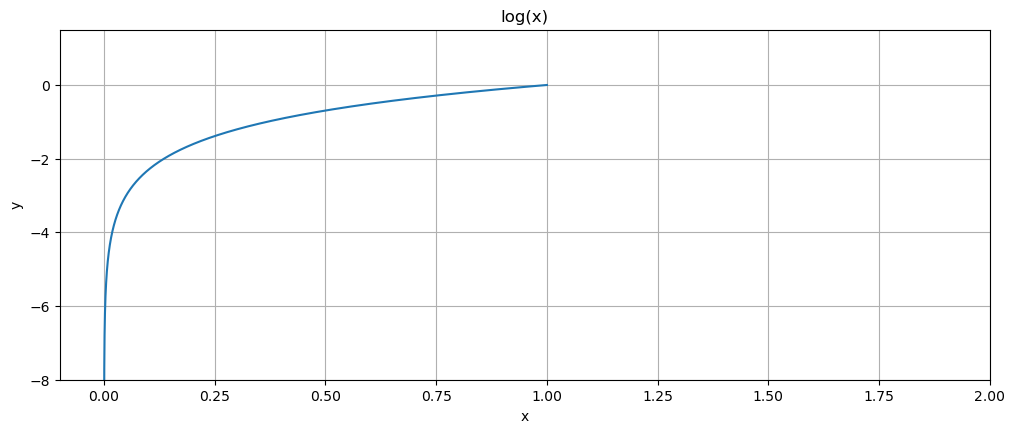

In [29]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from numpy import arange, sin, pi

#t = arange(1e-5, 5.0, 0.00001)
#t = arange(1.0, 5.0, 0.00001) # computer scientists
t = arange(0.0, 1.0, 0.00001)  # data     scientists

fig = figure(1,figsize=(12, 10))

ax1 = fig.add_subplot(211)
ax1.plot(t, np.log(t))
ax1.grid(True)
ax1.set_ylim((-8, 1.5))
ax1.set_xlim((-0.1, 2))
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('log(x)')

show()

## Confusion Matrix

A confusion matrix is a performance measurement tool used in machine learning for evaluating the accuracy of a classification model. It is a table that allows visualization of the performance of a model by comparing the actual values of the target variable with the predicted values. The confusion matrix is particularly useful for evaluating the performance of a classification model on a dataset with known class labels.

The confusion matrix is organized into a grid with four possible outcomes:

* **True Positives (TP):** The number of correct predictions that the model has made for the positive class.
* **True Negatives (TN):** The number of correct predictions that the model has made for the negative class.
* **False Positives (FP):** The number of incorrect predictions that the model has made, predicting a positive class when the actual class is negative (Type I error).
* **False Negatives (FN):** The number of incorrect predictions that the model has made, predicting a negative class when the actual class is positive (Type II error).

The confusion matrix enables the calculation of various evaluation metrics such as accuracy, precision, recall, F1 score, and specificity. These metrics help in assessing the model's performance, identifying potential areas for improvement, and making informed decisions about the model's effectiveness for the given classification task.

In other words, a confusion matrix shows which predicted classes are often confused for the other classes. The vertical axis (y) represents the true labels and the horizontal axis (x) represents the predicted labels. When the true label and predicted label are the same, the highest values occur down the diagonal extending from the upper left to the lower right. The other values, outside the diagonal, represent incorrect predictions. For example, in the confusion matrix below, the value in row 2, column 1 shows how often the predicted value A occurred when it should have been B.

### Example 13: Generate Confusion Matrix

The code in the cell below generates a Confusion Matrix for the model `ecgModel`. It uses the function `plot_confusion_matrix()` that was defined earlier in this lesson. To generate the Confusion Matrix, only two arguments need to be passed to the plotting function, the actual values of the `RestingEGC` of the patients in the validation set (i.e. `ecgY_compare`), and the model's predicted values for these patients (i.e. `ecgPred`). 

Normalized confusion matrix
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


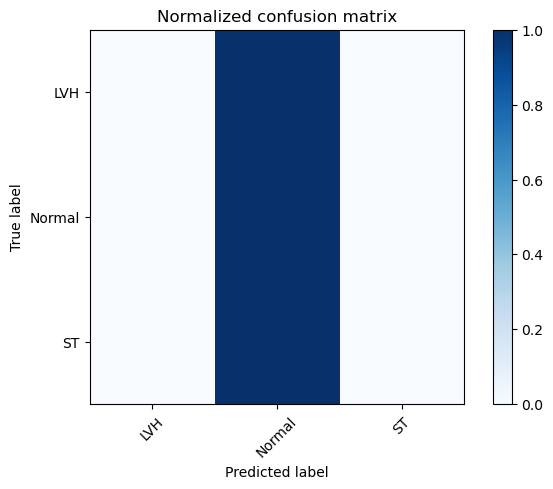

In [30]:
# Example 13: Generate confusion matrix

# Compute confusion matrix
cm = confusion_matrix(ecgY_compare, ecgPred)
np.set_printoptions(precision=2)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, ECGclasses, 
        title='Normalized confusion matrix')

plt.show()

If your code is correct you should see a figure similar to the one below:

![___](https://biologicslab.co/BIO1173/images/class_04_2_CM1.png)


In this particular Confusion Matrix shown above for the model `ecgModel`, indicates that it predicted the `RestingEGC` was normal for nearly **_every_** subject in the validation (test) set, irregardless of their actual type. The model was able to correctly identify patients with LVH only 8% of the time but missidentified the remaining 90%  as having a normal `RestingECG` the rest of the time. The model was never able to identify any of the patients in the validation data set who had a `RestingECG` of the type `ST`. 

Based on our results so far, we should expect your model `ifModel` to generate a much different looking Confusion Matrix.

### **Exercise 13: Generate Confusion Matrix**

In the cell below write the code to generate a Confusion Matrix for your Iris flower model, `ifModel`, using Example 13 as a template. Use the variable `IRIS_species` instead of `ECGclasses` when you give the command `plot_confusion_mactrix()`.

In [31]:
# Insert your code for Exericse 13 here

import numpy as np
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(ifY_compare, ifPred)
np.set_printoptions(precision=2)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, IRIS_species, 
        title='Normalized confusion matrix')

plt.show()

NameError: name 'ifY_compare' is not defined

If your code is correct you should see the figure below:

![___](https://biologicslab.co/BIO1173/images/class_04_2_CM2a.png)


### Analysis of the Confusion Matrix

Let's analyze the Confusion Matrix above to see what is says about your Iris Flower model, `ifModel`. 

Based on the Confusion Matrix your `ifModel` was able to predict, with 100% accuracy, the correct species of flowers obtained from both _`Iris setosa`_ (top left) and _`Iris virginica`_ (bottom right). The top left and bottom right squares in the Confusion Matrix are colored with the darkest possible shade of blue. According to the color key shown at the right of this image, this shade of dark blue represents a value of `1.0`, which means a perfect score.

When it came to flowers from the species, _`Iris versicolor`_, however, your model was accurate only about 90% of the time. Furthermore, based on the Confusion Matrix, when your model made a mistake, it invariably classified an _`Iris versicolor`_ flower as being from the species _`Iris virginica`_, but it _never_ confused the flower as being from the species _`Iris setosa`_. (Note light blue color panel in the center of the right side). 

If we wanted to improve our model, we should focus on ways to improve the model's ability to discrimate between flowers from these two species.


## **Lesson Turn-in**

When you have completed all of the code cells, and run them in sequential order (the last code cell should be number 31), use the **File --> Print.. --> Save to PDF** to generate a PDF of your JupyterLab notebook. Save your PDF as `Class_04_2.lastname.pdf` where _lastname_ is your last name, and upload the file to Canvas.